## Prerequisites

In [6]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [7]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

## Metadata

In [25]:
# dataset_meta = ['allen_'+x for x in ['B05','B08','C01','F08','H12','A08','B01']]

dataset_meta = ['allen_'+x for x in ['B05','B08','C01','F08','H12','B01','A01']]
dataset_names = [x for x in dataset_meta ]  
raw_data_locations = [x for x in dataset_meta]
transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/'+x+'_raw.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


In [26]:
dataset_names

['allen_B05',
 'allen_B08',
 'allen_C01',
 'allen_F08',
 'allen_H12',
 'allen_B01',
 'allen_A01']

In [27]:
len(np.unique(dataset_names))

7

## Filtering

In [28]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy


In [29]:
def get_allen_meta(directory):
    allen_membership = pd.read_csv(directory+'/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
    allen_annot = pd.read_csv(directory+'/cluster.annotation.csv')
    allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
    allen_membership['sample'] = allen_membership['barcode'].str[-3:]
    allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
    allen_annot.set_index('cluster_id',inplace=True)
    allen_annot_bc = allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)
    meta = pd.concat((allen_membership,allen_annot_bc),axis=1)
    return meta

In [30]:
meta_directory_v3 = '~/count_data/allen_metadata/sc'
meta_directory_v2 = '~/count_data/allen_metadata/sc_v2'
meta_v3 = get_allen_meta(meta_directory_v3)
meta_v2 = get_allen_meta(meta_directory_v2)

### Knee plot filtering and basic QC

In [39]:
replicates = ('B05','H12','A01')

Dataset B05. 
	5999 barcodes in loom, 5253 pass filter. 5442 in annotations; of these, 5440 in loom and 4886 in filtered loom.
Dataset B08. 
	10975 barcodes in loom, 9216 pass filter. 8424 in annotations; of these, 8424 in loom and 7808 in filtered loom.
Dataset C01. 
	12363 barcodes in loom, 11116 pass filter. 10173 in annotations; of these, 10138 in loom and 9066 in filtered loom.
Dataset F08. 
	28362 barcodes in loom, 10039 pass filter. 9112 in annotations; of these, 9112 in loom and 8510 in filtered loom.
Dataset H12. 
	9637 barcodes in loom, 8168 pass filter. 6866 in annotations; of these, 6865 in loom and 6161 in filtered loom.
Dataset B01. 
	11504 barcodes in loom, 9673 pass filter. 9772 in annotations; of these, 9772 in loom and 8764 in filtered loom.
Dataset A01. 
	8145 barcodes in loom, 6443 pass filter. 6355 in annotations; of these, 6355 in loom and 5797 in filtered loom.


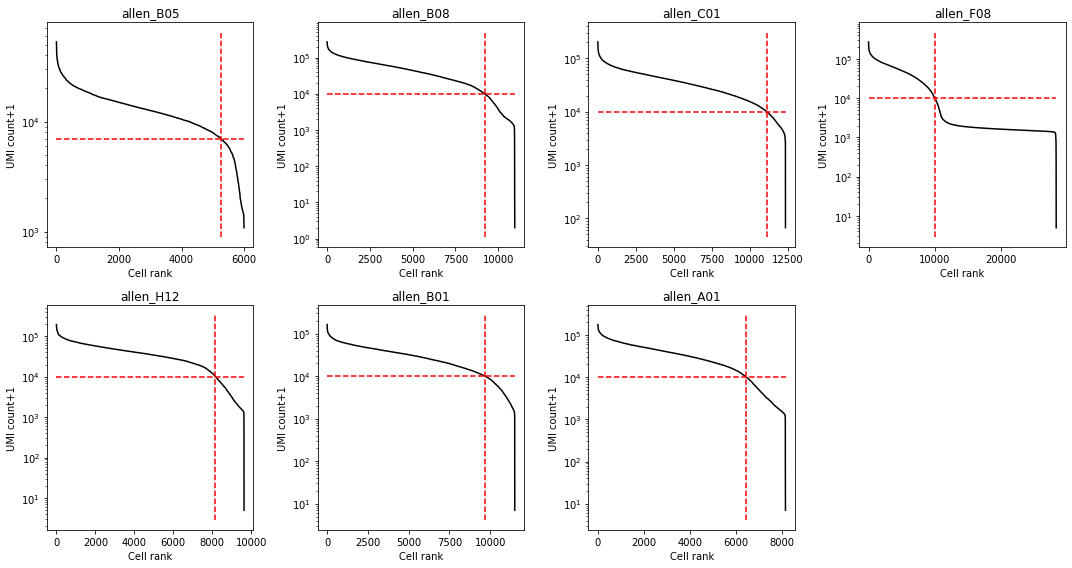

In [40]:
cf = []
thr_lb = [7e3] + [1e4]*6
# thr_lb = [1e3,3e3,3e3]
S_arr = []
U_arr = []
fig1,ax1 = plt.subplots(2,4,figsize=(15,8))

for k in range(len(dataset_meta)):
# for k in range(1):
    axloc = np.unravel_index(k,(2,4))
    filename = loom_filepaths[k ]
    dataset_name = raw_data_locations[k][-3:]
    
    if k > 0:
        meta = meta_v3
    else:
        meta = meta_v2
#     clusters = cluster_annotations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[axloc],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = (meta['sample']==dataset_name).sum()
        annot_bcs_in_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        annot_bcs = meta[(meta['sample']==dataset_name)]['cell_barcode']
#         cf
        if dataset_name in replicates:
            S_arr.append(S)
            U_arr.append(U)
        cf.append(np.isin(bcs,annot_bcs) & cf_)
#             print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')

    ax1[axloc].set_title(raw_data_locations[k])
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_allen.png'
plt.delaxes(ax1[1,3])
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)


### v2/v3 comparison

B05 is a male mouse squeakenced by v2. F08 and G08, two libraries generated from a single male mouse, were processed with v3.

Here, we compare the $\text{CV}^2$ values. They are much higher for the v2 datase, presumably due to technical noise.

/tmp/ipykernel_3630359/440059537.py:11: RuntimeWarning: invalid value encountered in divide
  x = x.var(1)/(x.mean(1)**2)
/tmp/ipykernel_3630359/440059537.py:12: RuntimeWarning: invalid value encountered in divide
  y = y.var(1)/(y.mean(1)**2)


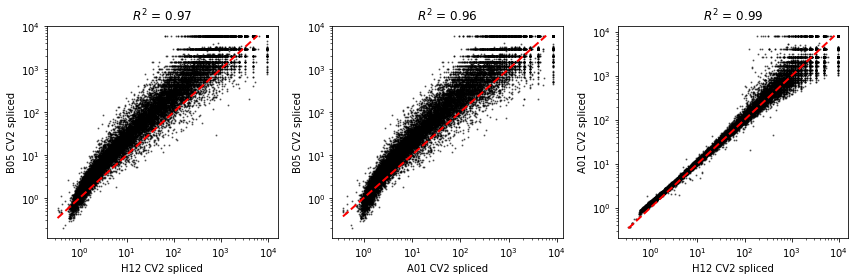

In [41]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = S_arr[k1]
    y = S_arr[k2]
    x = x.var(1)/(x.mean(1)**2)
    y = y.var(1)/(y.mean(1)**2)

    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(replicates[k1]+' CV2 spliced')
    ax1[q].set_ylabel(replicates[k2]+' CV2 spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

/tmp/ipykernel_3630359/657333974.py:11: RuntimeWarning: invalid value encountered in divide
  x = x.var(1)/(x.mean(1)**2)
/tmp/ipykernel_3630359/657333974.py:12: RuntimeWarning: invalid value encountered in divide
  y = y.var(1)/(y.mean(1)**2)


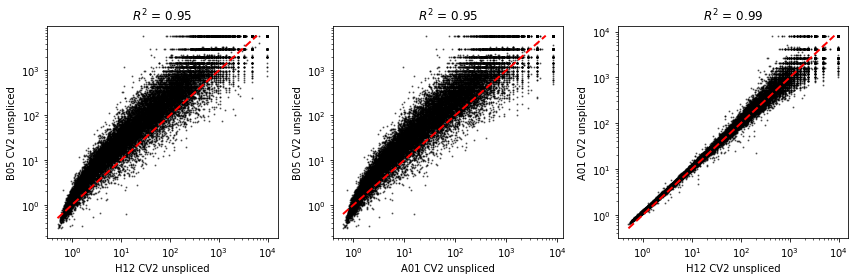

In [42]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = U_arr[k1]
    y = U_arr[k2]
    x = x.var(1)/(x.mean(1)**2)
    y = y.var(1)/(y.mean(1)**2)

    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(replicates[k1]+' CV2 unspliced')
    ax1[q].set_ylabel(replicates[k2]+' CV2 unspliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

Meanwhile, the mean levels are lower in the v2 dataset.

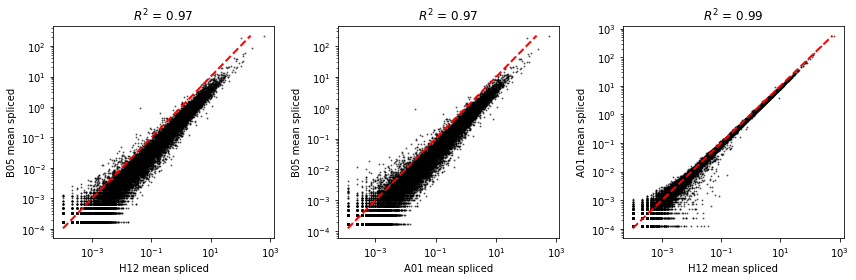

In [43]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = S_arr[k1]
    y = S_arr[k2]
    x = x.mean(1)
    y = y.mean(1)

    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(replicates[k1]+' mean spliced')
    ax1[q].set_ylabel(replicates[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

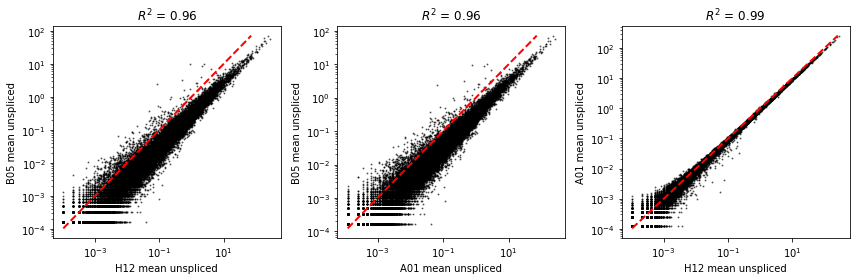

In [44]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = U_arr[k1]
    y = U_arr[k2]
    x = x.mean(1)
    y = y.mean(1)

    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(replicates[k1]+' mean unspliced')
    ax1[q].set_ylabel(replicates[k2]+' mean unspliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [45]:
[x.sum() for x in cf]


[4886, 7808, 9066, 8510, 6161, 8764, 5797]

## Preprocessing

In [46]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_221118_025_allen_1 created.
INFO:root:Dataset: allen_B05
INFO:root:4886 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:3523 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B05 created.
INFO:root:Dataset: allen_B08
INFO:root:7808 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:8702 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B08 created.
INFO:root:Dataset: allen_C01
INFO:root:9066 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7683 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_C01 created.
INFO:root:Dataset: allen_F08
INFO:root:8510 cells detected.
INFO:root:32285 featu

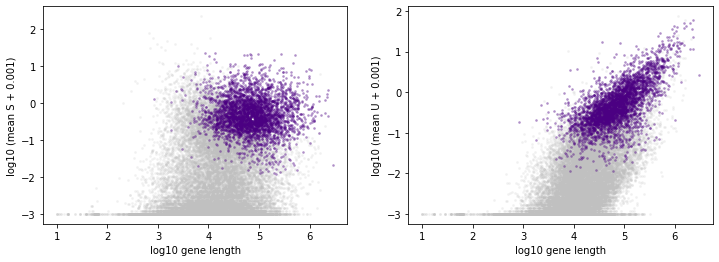

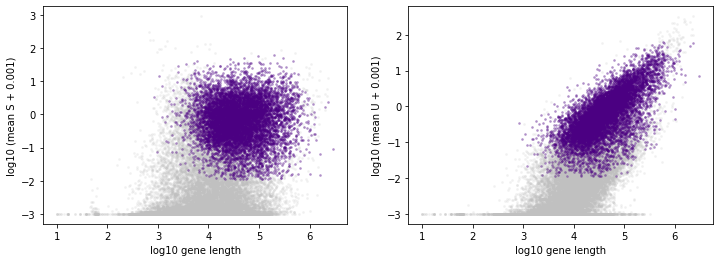

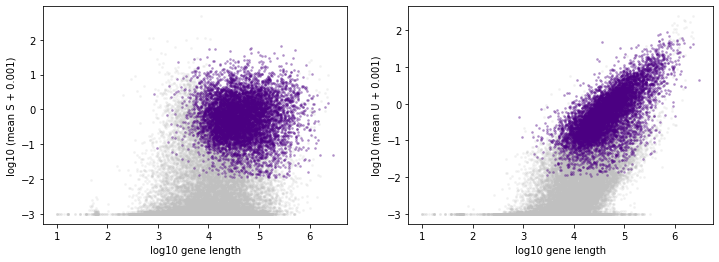

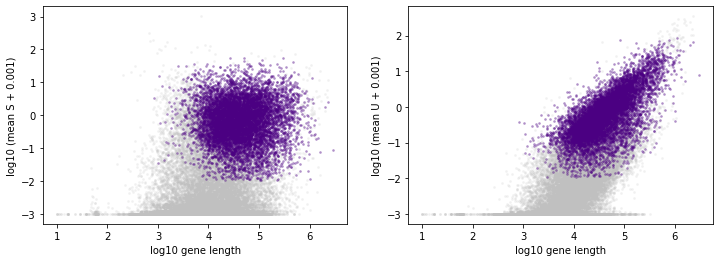

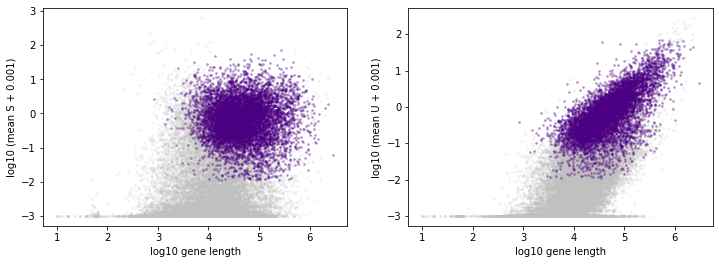

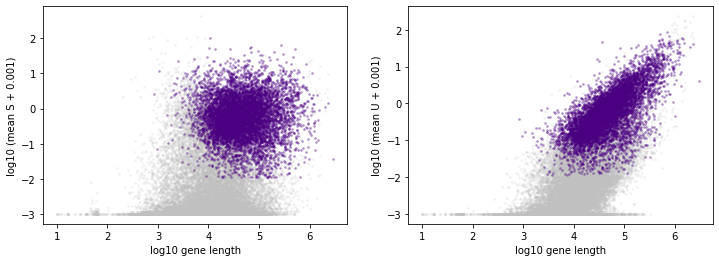

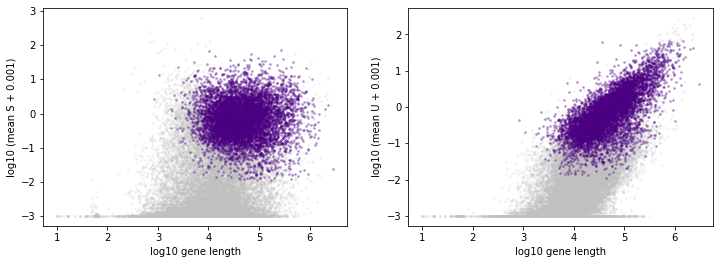

In [47]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen',batch_id=1,\
                                             n_genes=2500,exp_filter_threshold=None,cf=cf)

## Inference

In [48]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [49]:
dataset_names

['allen_B05',
 'allen_B08',
 'allen_C01',
 'allen_F08',
 'allen_H12',
 'allen_B01',
 'allen_A01']

In [ ]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-8, -2.5]
samp_ub = [-5, 0]
gridsize = [20,21]



result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
#                 gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':3})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(40,search_data)
    result_strings.append(full_result_string)


INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B05
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B05/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_allen_1/allen_B05/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [35:17<00:00,  5.04s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B05/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 2120.6 seconds.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B08/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_allen_1/allen_B08/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B08/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_allen_1/allen_B08/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [4:34:17<00:00, 39.18s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_B08/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 16463.8 seconds.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_C01/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_allen_1/allen_C01/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_C01
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_allen_1/allen_C01/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_allen_1/allen_C01/raw.sd.
INFO:root:Starting parallelized grid scan.


 40%|█████████████████████████████████████████                                                             | 169/420 [38:00<3:08:48, 45.13s/it]

## Post-processing

In [ ]:
dataset_names

In [ ]:
dir_string

In [ ]:
result_strings

In [ ]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=0.01) 

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)


In [7]:
dir_string = './fits/gg_221118_025_allen_1'
result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results.res' for x in dataset_names]

In [303]:
sr_arr = [ monod.analysis.load_search_results(x) for x in result_strings]
sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]

INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_1k_v2_Tcells/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_1k_v2_Monocytes/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_1k_v2_Bcells/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_1k_v3_Tcells/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_1k_v3_Monocytes/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_1k_v3_Bcells/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_10k_v3_Tcells/Burst

## Analysis

In [ ]:
# sz=(3,4)
sz = (2,4)
fig1,ax1 = plt.subplots(sz[0],sz[1],figsize=(15,8))
for j,sr in enumerate(sr_arr):
    axloc = np.unravel_index(j,sz)
    sr.plot_landscape(ax1[axloc],discard_rejected=True)
plt.delaxes(ax1[1,3])
fig1.tight_layout()


In [ ]:
opt = []
n_cells = []
for i in range(n_datasets):
    opt.append(sr_arr[i].samp_optimum)
    n_cells.append(sr_arr[i].n_cells)
opt = np.asarray(opt)
n_cells = np.asarray(n_cells)


In [ ]:
n_cells

In [ ]:
import matplotlib

In [ ]:
fs = 20

sr = sr_arr[0]
xl = np.asarray([sr.sp.samp_lb[0],sr.sp.samp_ub[0]])
yl = np.asarray([sr.sp.samp_lb[1],sr.sp.samp_ub[1]])
x=np.linspace(xl[0],xl[1],sr.sp.gridsize[0])
y=np.linspace(yl[0],yl[1],sr.sp.gridsize[1])


d=0.1

fig1,ax1 = plt.subplots(1,1,figsize=(8,8))
for i in range(sr.sp.gridsize[0]):
    plt.plot([x[i]]*2,yl + [-d,d],c='whitesmoke')
for i in range(sr.sp.gridsize[1]):
    plt.plot(xl+ [-d,d],[y[i]]*2,c='whitesmoke')
jit = np.random.randn(n_datasets,2)*0.02
opt_ = opt+jit
cmap = 'cool'

ctf = range(1,n_datasets)
plt.scatter(opt_[ctf,0],opt_[ctf,1],100,n_cells[ctf],zorder=1000,
            alpha=0.3,cmap=cmap,label='10x v3',norm=matplotlib.colors.LogNorm(vmin=100,vmax=12000))
stf = range(1)
plt.scatter(opt_[stf,0],opt_[stf,1],80,n_cells[stf],marker='^',zorder=1000,
            alpha=0.5,cmap=cmap,label='10x v2',norm=matplotlib.colors.LogNorm(vmin=100,vmax=12000))
# ctf = range(4,n_datasets)
# plt.scatter(opt_[ctf,0],opt_[ctf,1],100,n_cells[ctf],zorder=1000,
#             alpha=0.3,cmap=cmap,label='10x v2',vmin=0,vmax=12000,norm=matplotlib.colors.LogNorm())
# stf = range(4)
# plt.scatter(opt_[stf,0],opt_[stf,1],80,n_cells[stf],marker='^',zorder=1000,
#             alpha=0.5,cmap=cmap,label='10x v3',vmin=0,vmax=12000,norm=matplotlib.colors.LogNorm())
plt.xlim(xl+ [-d,d])
plt.ylim(yl+ [-d,d])

plt.legend(fontsize=fs,loc='upper left')
plt.colorbar(label='Number of cells')

plt.xlabel(r'$\log_{10} C_N$',fontsize=fs)
plt.ylabel(r'$\log_{10} \lambda_M$',fontsize=fs)

# fig_string = sr.batch_analysis_string+'/landscape_qc.png'
# plt.savefig(fig_string,dpi=450)


In [77]:
sr_arr[0].samp_optimum

(-6.7368421052631575, -0.875)

In [78]:
dataset_names

['allen_B05',
 'allen_B08',
 'allen_C01',
 'allen_F08',
 'allen_H12',
 'allen_C01',
 'allen_G12']

In [80]:
sr_arr[0].set_sampling_optimum(np.argmin(((sr_arr[0].param_estimates[:,~sr_arr[4].rejected_genes,:] - sr_arr[4].phys_optimum[~sr_arr[4].rejected_genes])**2).sum((1,2))))
sr_arr[0].chisquare_testing(sd_arr[0],threshold=1e-6)

(array([  58.00521315,   76.91817176,    5.58637371, ...,   40.40584115,
          11.5011207 , 1134.19524474]),
 array([1.21492196e-004, 6.20587993e-007, 4.71079349e-001, ...,
        3.55774731e-002, 4.02284406e-001, 3.06276866e-213]))

In [81]:
sr_arr[0].samp_optimum

(-6.7368421052631575, -1.125)

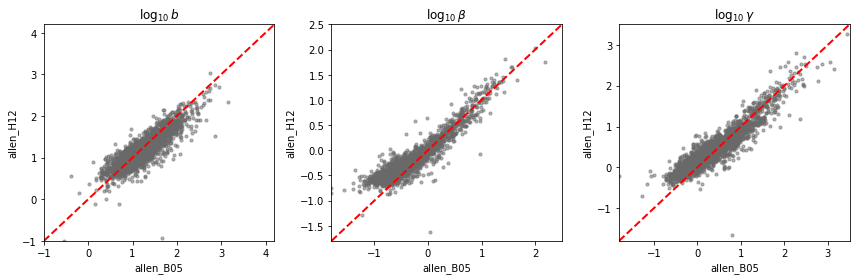

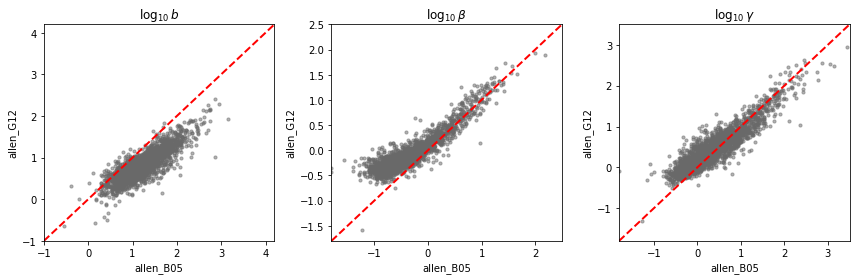

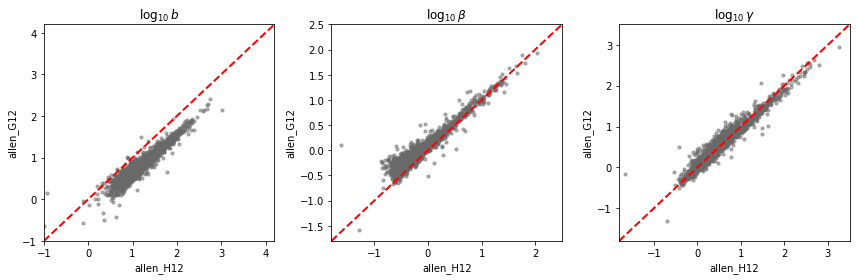

In [83]:
pairs = [[0,4],[0,6],[4,6]]
for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]
    monod.analysis.plot_params_for_pair(sr_arr[k1],sr_arr[k2],
                                        distinguish_rej=False,plot_errorbars=False,xlabel=dataset_names[k1],
                                   ylabel=dataset_names[k2])


In [89]:
search_data = sd_arr[j]

In [90]:
csqarr = []


In [93]:
hist_type = monod.inference.get_hist_type(search_data)

In [94]:
hist_type

'unique'

In [116]:
observed[b_]


15.999999999999996

In [117]:
(counts[bins==b_].sum())

15.999999999999996

In [ ]:
sr_arr[5].sam

In [30]:
sr_arr[2].set_sampling_optimum(328)

(-5.631578947368421, -0.875)

In [28]:
sr_arr[5].samp_optimum_ind

328

In [42]:
# thr=1e-12
# _=sr_arr[0].chisquare_testing(sd_arr[0],threshold=thr)
# _=sr_arr[3].chisquare_testing(sd_arr[3],threshold=thr)

INFO:root:Chi-square computation complete. Rejected 107 genes out of 3000. Runtime: 6.0 seconds.
INFO:root:Chi-square computation complete. Rejected 901 genes out of 3000. Runtime: 9.7 seconds.


### T-cells

In [84]:
dataset_names

['10x_pbmc_1k_v2_Tcells',
 '10x_pbmc_1k_v2_Monocytes',
 '10x_pbmc_1k_v2_Bcells',
 '10x_pbmc_1k_v2_All',
 '10x_pbmc_1k_v3_Tcells',
 '10x_pbmc_1k_v3_Monocytes',
 '10x_pbmc_1k_v3_Bcells',
 '10x_pbmc_1k_v3_All',
 '10x_pbmc_10k_v3_Tcells',
 '10x_pbmc_10k_v3_Monocytes',
 '10x_pbmc_10k_v3_Bcells',
 '10x_pbmc_10k_v3_All']

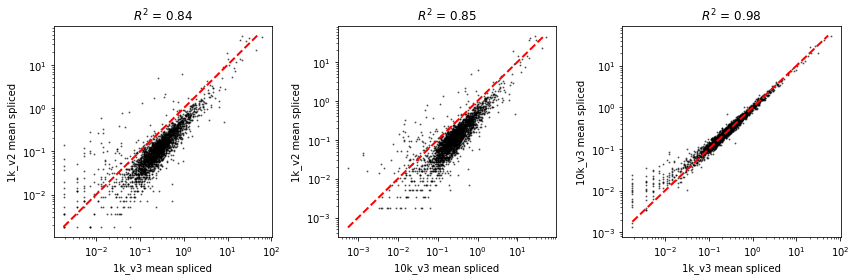

In [90]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*4].layers[1]
    y = sd_arr[k2*4].layers[1]
    x = x.mean(1)
    y = y.mean(1)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

/tmp/ipykernel_1595883/3430383092.py:11: RuntimeWarning: invalid value encountered in divide
  x = x.var(1)/(x.mean(1)**2)
/tmp/ipykernel_1595883/3430383092.py:12: RuntimeWarning: invalid value encountered in divide
  y = y.var(1)/(y.mean(1)**2)


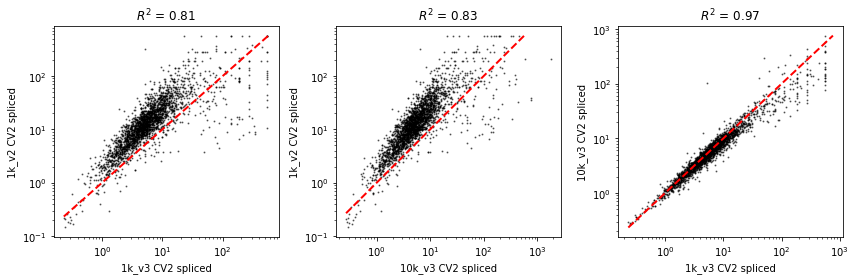

In [91]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*4].layers[1]
    y = sd_arr[k2*4].layers[1]
    x = x.var(1)/(x.mean(1)**2)
    y = y.var(1)/(y.mean(1)**2)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' CV2 spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' CV2 spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [92]:
sr_arr[0].samp_optimum

(-5.947368421052632, -0.625)

In [352]:
sr_arr[6].samp_optimum

(-5.473684210526316, -0.75)

In [353]:
sr_arr[0].samp_optimum_ind

246

In [354]:
sr_arr[6].samp_optimum_ind

350

In [355]:
sr_arr[0].set_sampling_optimum(np.argmin(((sr_arr[0].param_estimates[:,~sr_arr[6].rejected_genes,:] - sr_arr[6].phys_optimum[~sr_arr[6].rejected_genes])**2).sum((1,2))))
sr_arr[0].chisquare_testing(sd_arr[0],threshold=1e-6)

INFO:root:Chi-square computation complete. Rejected 183 genes out of 2500. Runtime: 2.7 seconds.


(array([11.55801876,  5.6916193 ,  5.08663127, ..., 15.0972433 ,
        17.47350333,  4.6791198 ]),
 array([0.00906125, 0.22339238, 0.02411098, ..., 0.08829927, 0.06452144,
        0.09637004]))

In [356]:
sr_arr[0].samp_optimum

(-5.631578947368421, -0.875)

INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.


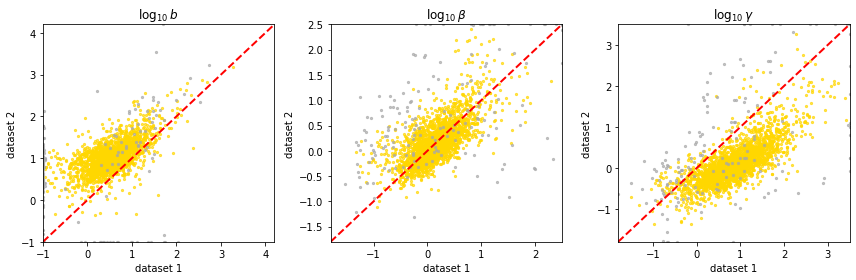

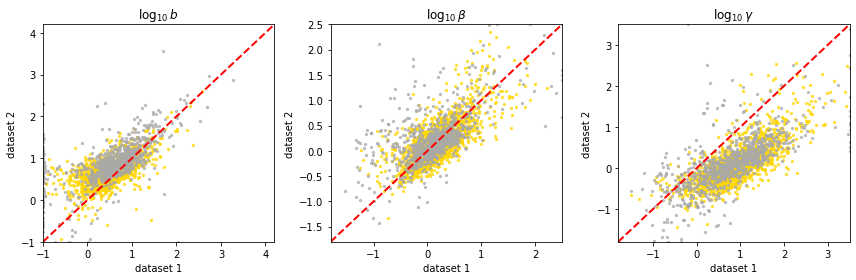

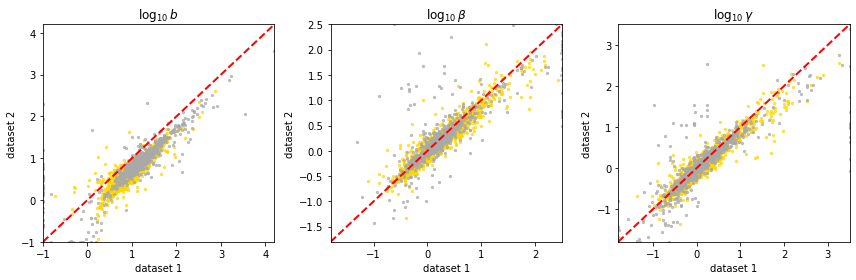

In [93]:
monod.analysis.plot_params_for_pair(sr_arr[0],sr_arr[4])
monod.analysis.plot_params_for_pair(sr_arr[0],sr_arr[8])
monod.analysis.plot_params_for_pair(sr_arr[4],sr_arr[8])


### Monocytes

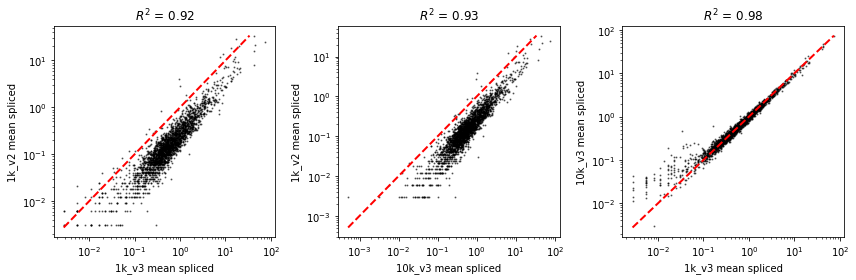

In [94]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*4+1].layers[1]
    y = sd_arr[k2*4+1].layers[1]
    x = x.mean(1)
    y = y.mean(1)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

/tmp/ipykernel_1595883/1969919893.py:11: RuntimeWarning: invalid value encountered in divide
  x = x.var(1)/(x.mean(1)**2)
/tmp/ipykernel_1595883/1969919893.py:12: RuntimeWarning: invalid value encountered in divide
  y = y.var(1)/(y.mean(1)**2)


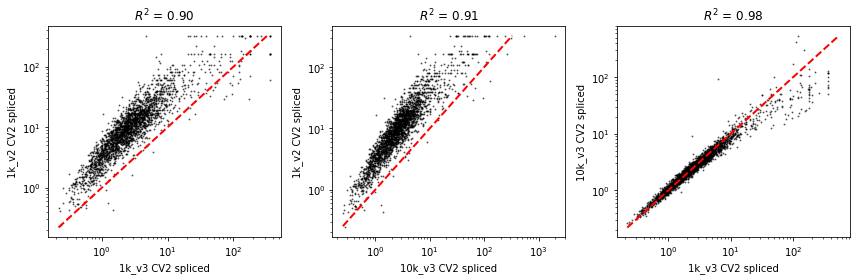

In [95]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*4+1].layers[1]
    y = sd_arr[k2*4+1].layers[1]
    x = x.var(1)/(x.mean(1)**2)
    y = y.var(1)/(y.mean(1)**2)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' CV2 spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' CV2 spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [232]:
sr_arr[1].set_sampling_optimum(np.argmin(((sr_arr[1].param_estimates[:,~sr_arr[7].rejected_genes,:] - sr_arr[7].phys_optimum[~sr_arr[7].rejected_genes])**2).sum((1,2))))
sr_arr[1].chisquare_testing(sd_arr[1],threshold=1e-6)

INFO:root:Chi-square computation complete. Rejected 108 genes out of 2500. Runtime: 2.6 seconds.


(array([ 0.70215438,  4.7959536 ,  0.27308779, ..., 14.55792608,
         0.85583671,  1.60059856]),
 array([0.70392942, 0.18736285,        nan, ..., 0.02398827, 0.35490639,
               nan]))

In [233]:
sr_arr[1].samp_optimum_ind

262

In [234]:
sr_arr[7].samp_optimum_ind

284

INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.


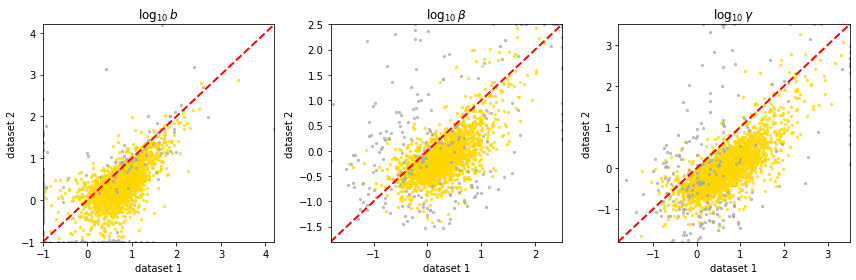

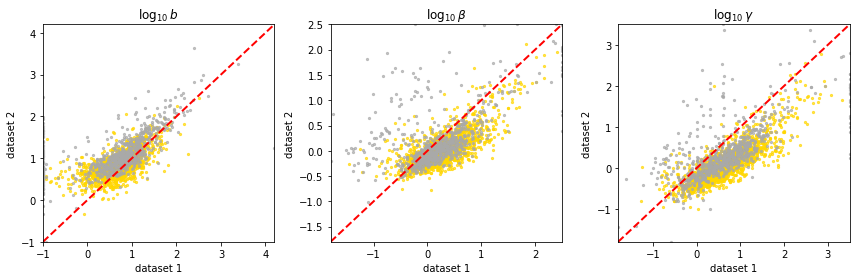

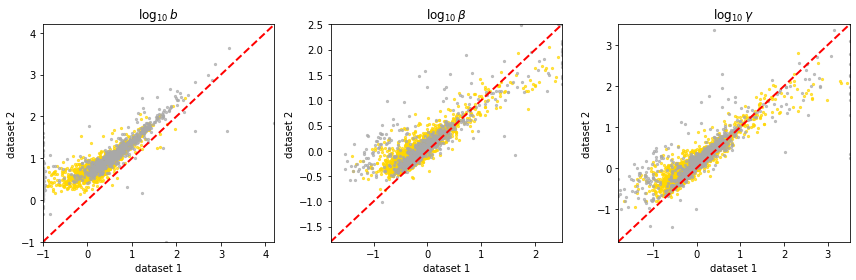

In [96]:
monod.analysis.plot_params_for_pair(sr_arr[1],sr_arr[5])
monod.analysis.plot_params_for_pair(sr_arr[1],sr_arr[9])
monod.analysis.plot_params_for_pair(sr_arr[5],sr_arr[9])


### B cells

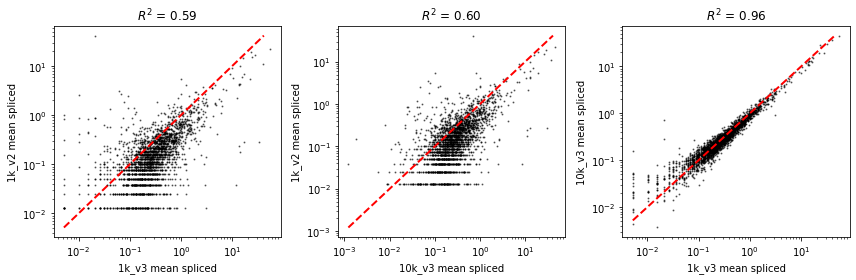

In [97]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*4+2].layers[1]
    y = sd_arr[k2*4+2].layers[1]
    x = x.mean(1)
    y = y.mean(1)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

/tmp/ipykernel_1595883/3717370790.py:11: RuntimeWarning: invalid value encountered in divide
  x = x.var(1)/(x.mean(1)**2)
/tmp/ipykernel_1595883/3717370790.py:12: RuntimeWarning: invalid value encountered in divide
  y = y.var(1)/(y.mean(1)**2)


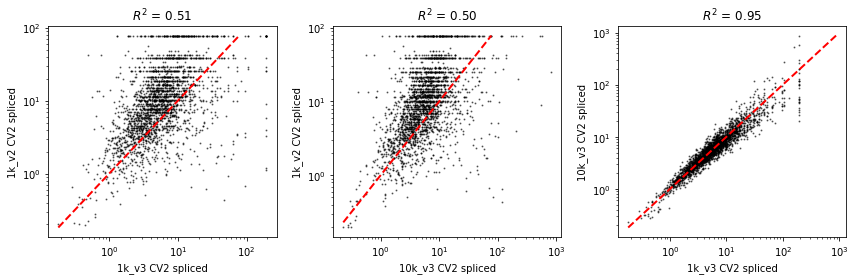

In [98]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*4+2].layers[1]
    y = sd_arr[k2*4+2].layers[1]
    x = x.var(1)/(x.mean(1)**2)
    y = y.var(1)/(y.mean(1)**2)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' CV2 spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' CV2 spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [238]:
sr_arr[2].set_sampling_optimum(np.argmin(((sr_arr[2].param_estimates[:,~sr_arr[8].rejected_genes,:] - sr_arr[8].phys_optimum[~sr_arr[8].rejected_genes])**2).sum((1,2))))
sr_arr[2].chisquare_testing(sd_arr[2],threshold=1e-6)

INFO:root:Chi-square computation complete. Rejected 515 genes out of 2500. Runtime: 2.3 seconds.


(array([1.62626891e-01, 6.15881860e-01, 1.57531340e-01, ...,
        2.11040085e+01, 1.08199339e+00, 2.72776318e-06]),
 array([       nan,        nan,        nan, ..., 0.00030198, 0.29825205,
               nan]))

In [267]:
search_data

In [268]:
sr = sr_arr[2]
search_data = sd_arr[2]
sd = sd_arr[2]

In [269]:
csqarr = []
hist_type = monod.inference.get_hist_type(sd)
for gene_index in range(sr.n_genes):
    lm = search_data.M[:, gene_index]
    expect_freq = sr.model.eval_model_pss(
        sr.phys_optimum[gene_index], lm, sr.regressor_optimum[gene_index] 
    ) * search_data.n_cells

    if hist_type == "grid":
        raise ValueError('Not implemented in current version.')
    elif hist_type == "unique":
        counts = np.concatenate(
            (search_data.n_cells * search_data.hist[gene_index][1], [0])
        )
        expect_freq = expect_freq[
            search_data.hist[gene_index][0][:, 0],
            search_data.hist[gene_index][0][:, 1],
        ]
        expect_freq = np.concatenate(
            (expect_freq, [search_data.n_cells - expect_freq.sum()])
        )

    bins = []
    bin_ind = 0
    run_bin_obs = 0
    run_bin_exp = 0
    bin_obs = []
    bin_exp = []
    for i in range(len(counts)):
        bins.append(bin_ind)
        run_bin_obs += counts[i]
        run_bin_exp += expect_freq[i]
        if min(run_bin_obs,run_bin_exp) < 5:# and i
            pass
        else:
            bin_ind += 1
            bin_obs.append(run_bin_obs)
            bin_exp.append(run_bin_exp)
            run_bin_obs = 0
            run_bin_exp = 0
    bins=np.asarray(bins)
    observed = np.asarray(bin_obs)
    proposed = np.asarray(bin_exp)
    observed[-1] += run_bin_obs
    proposed[-1] += run_bin_exp
    bins[bins==len(observed)] = len(observed)-1

    for b_ in range(len(bin_obs)): 
        assert np.isclose(observed[b_],counts[bins==b_].sum())
        assert np.isclose(proposed[b_],expect_freq[bins==b_].sum())
    assert np.isclose(observed.sum(),search_data.n_cells)
    assert np.isclose(proposed.sum(),search_data.n_cells)
    assert np.isclose(search_data.n_cells,counts.sum())
    assert np.isclose(search_data.n_cells,expect_freq.sum())
    csqarr += [
        scipy.stats.mstats.chisquare(
            observed, proposed,#chisq_data, chisq_prop, 
            sr.model.get_num_params()
        )
    ]


In [281]:
counts

array([71.,  1.,  5.,  1.,  1.,  0.])

In [283]:
expect_freq

array([70.99557034,  0.55825023,  5.36999185,  1.20185915,  0.31704972,
        0.55727871])

In [286]:
scipy.stats.mstats.chisquare(
            observed, proposed,0)

Power_divergenceResult(statistic=2.727763180210029e-06, pvalue=0.9986822191396537)

In [275]:
observed

array([71.,  8.])

In [270]:
bonferroni = True
threshold = 1e-6
reject_at_bounds=True
bound_thr = 1e-2
csq, pval = zip(*csqarr)
csq = np.asarray(csq)
pval = np.asarray(pval)

if bonferroni:
    threshold /= sr.n_genes
rejected_genes = pval < threshold

if reject_at_bounds:
    bound_range = sr.sp.phys_ub - sr.sp.phys_lb
    lb = sr.sp.phys_lb + bound_range * bound_thr
    ub = sr.sp.phys_ub - bound_range * bound_thr

    rej_poor_fit = ((sr.phys_optimum < lb) | (sr.phys_optimum > ub)).any(1)
    rejected_genes = (rejected_genes) | rej_poor_fit


In [273]:
pval

array([       nan,        nan,        nan, ..., 0.00030198, 0.29825205,
              nan])

In [272]:
sr.rejected_genes.sum()

515

INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.


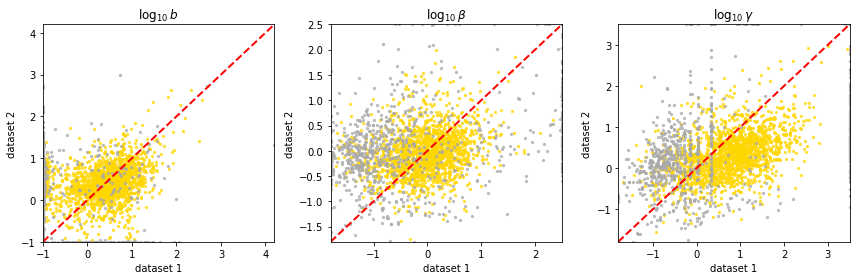

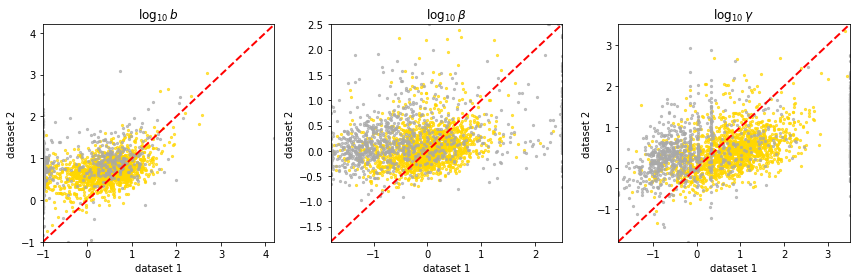

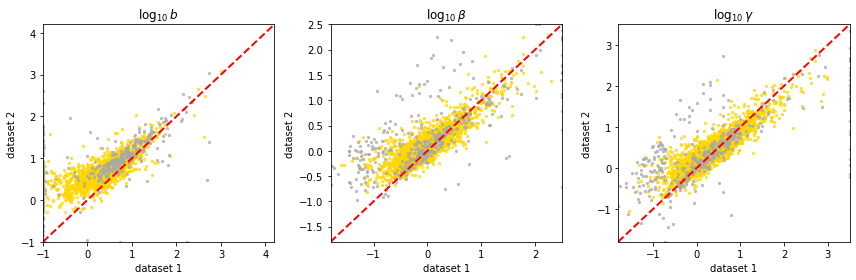

In [99]:
monod.analysis.plot_params_for_pair(sr_arr[2],sr_arr[6])
monod.analysis.plot_params_for_pair(sr_arr[2],sr_arr[10])
monod.analysis.plot_params_for_pair(sr_arr[6],sr_arr[10])


### All

In [101]:
sr_arr[3].samp_optimum

(-5.7894736842105265, -0.625)

In [102]:
sr_arr[7].samp_optimum

(-5.631578947368421, -0.625)

In [103]:
sr_arr[11].samp_optimum

(-5.631578947368421, -0.625)

In [112]:
np.argmin((np.abs(sr_arr[3].param_estimates[:,~sr_arr[11].rejected_genes,:] - sr_arr[11].phys_optimum[~sr_arr[11].rejected_genes])).sum((1,2)))

285

In [106]:
sr_arr[3].samp_optimum_ind

309

In [109]:
sr_arr[3].set_sampling_optimum(285)
_=sr_arr[3].chisquare_testing(sd_arr[3],threshold=1e-6)

INFO:root:Chi-square computation complete. Rejected 62 genes out of 2500. Runtime: 3.1 seconds.


In [111]:
sr_arr[3].samp_optimum

(-5.947368421052632, -1.0)

INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.


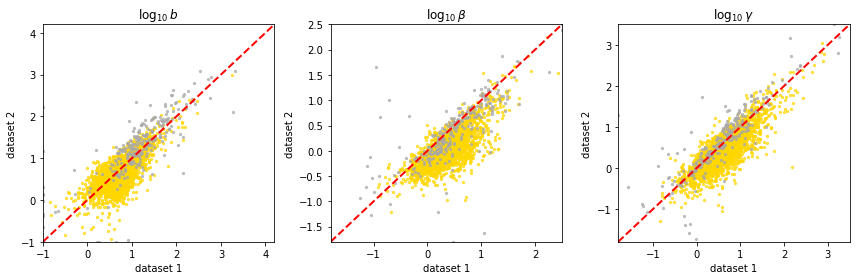

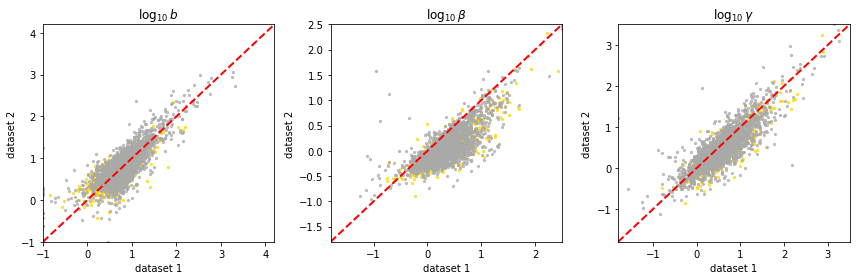

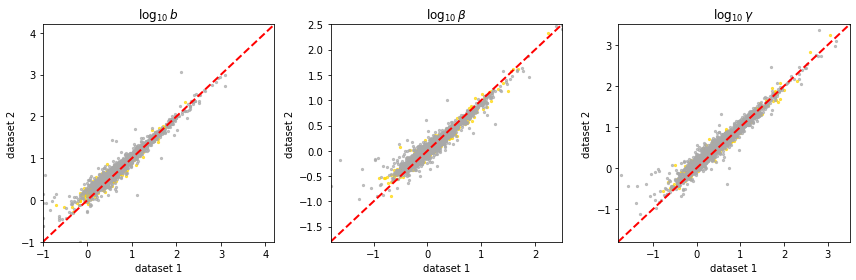

In [110]:
monod.analysis.plot_params_for_pair(sr_arr[3],sr_arr[7])
monod.analysis.plot_params_for_pair(sr_arr[3],sr_arr[11])
monod.analysis.plot_params_for_pair(sr_arr[7],sr_arr[11])


### Controls

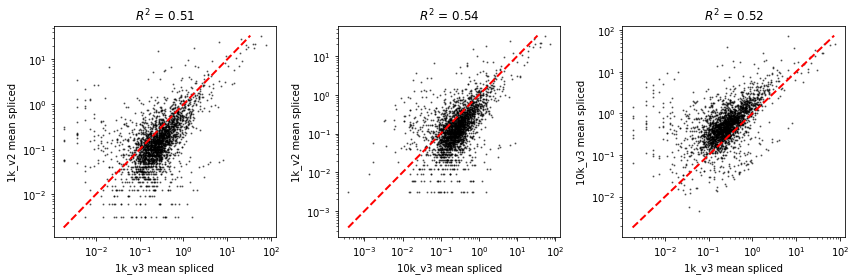

In [295]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*3].layers[1]
    y = sd_arr[k2*3+1].layers[1]
    x = x.mean(1)
    y = y.mean(1)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

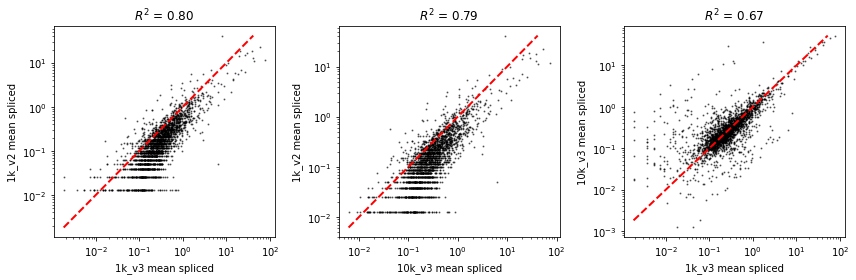

In [296]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*3].layers[1]
    y = sd_arr[k2*3+2].layers[1]
    x = x.mean(1)
    y = y.mean(1)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

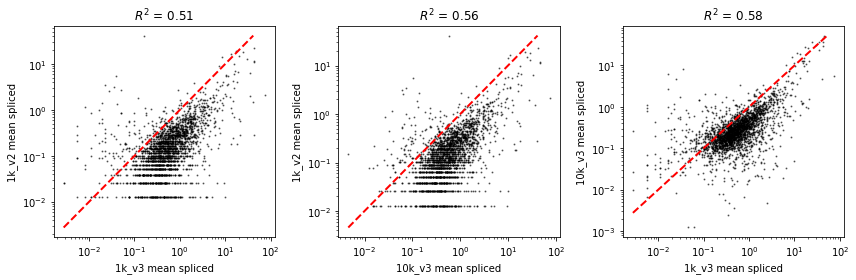

In [297]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*3+1].layers[1]
    y = sd_arr[k2*3+2].layers[1]
    x = x.mean(1)
    y = y.mean(1)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [25]:
df = np.abs(sr_arr[3].phys_optimum-sr_arr[4].phys_optimum)

In [16]:
top_genes = np.argsort(df,0)[:50]

In [17]:
sr_arr[3].gene_names[top_genes]

array([['CAMTA1', 'ANP32E', 'BLK'],
       ['FEZ2', 'DNAJC21', 'DIAPH1'],
       ['CBX1', 'FGFR1OP2', 'GIGYF1'],
       ['HMCES', 'RBM27', 'SP110'],
       ['UHRF1', 'ID2', 'PARP14'],
       ['SYNRG', 'ARGLU1', 'NPM1'],
       ['ITGAX', 'ALG5', 'MESD'],
       ['PDS5B', 'ITGB3BP', 'PCM1'],
       ['CABIN1', 'RC3H2', 'PKN1'],
       ['CD46', 'MESD', 'PLEKHA3'],
       ['RPL41', 'CNOT7', 'ARID1B'],
       ['CD69', 'ZFR', 'RPL24'],
       ['PRPS1', 'PUM1', 'CAPZB'],
       ['MAPRE2', 'PIAS1', 'RAP1GDS1'],
       ['ZRSR2', 'RAP2A', 'TBL1XR1'],
       ['NELL2', 'EIF3A', 'LNPEP'],
       ['MLXIP', 'TMEM50A', 'PMPCB'],
       ['SAMD8', 'TMEM131', 'BTN3A2'],
       ['LRPPRC', 'CEBPZ', 'BMS1'],
       ['ELOVL5', 'NCOA2', 'CLSTN1'],
       ['TPR', 'AKAP13', 'SYAP1'],
       ['SKAP2', 'AMD1', 'SLC35C2'],
       ['MRPS35', 'ERBIN', 'SFPQ'],
       ['APC', 'RNASET2', 'NDUFS5'],
       ['EIF2B1', 'MICU2', 'HSP90AB1'],
       ['RP2', 'GATAD2A', 'TMEM123'],
       ['THOC2', 'SFSWAP', 'UVRAG'],
       

In [18]:
np.where(sr_arr[3].gene_names=='CD4')

(array([527]),)

In [19]:
gi = 629
gi = np.where(sd_arr[0].gene_names=='CD69')
gi = np.where(sd_arr[0].gene_names=='CD36')

In [20]:
sd_arr[3].layers[1,gi].mean()

0.03596179059749017

In [21]:
sd_arr[4].layers[1,gi].mean()

4.354691075514874

In [90]:
'CD36' in sd_arr[0].gene_names

True

INFO:root:Figure stored to ./fits/gg_221108_025_pbmc_celltypes_3/analysis_figures/pair_parameter_comparison_12.png.


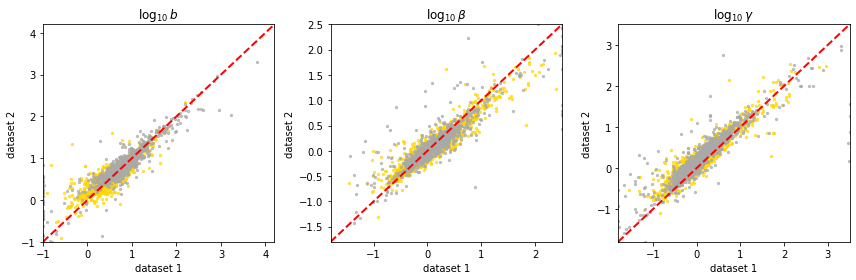

In [26]:
monod.analysis.plot_params_for_pair(sr_arr[0],sr_arr[3])

INFO:root:Figure stored to ./fits/gg_221108_025_pbmc_celltypes_3/analysis_figures/pair_parameter_comparison_12.png.


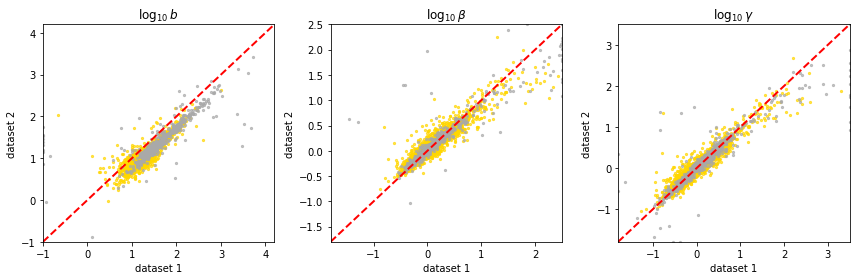

In [27]:
monod.analysis.plot_params_for_pair(sr_arr[1],sr_arr[4])

INFO:root:Figure stored to ./fits/gg_221108_025_pbmc_celltypes_3/analysis_figures/pair_parameter_comparison_12.png.


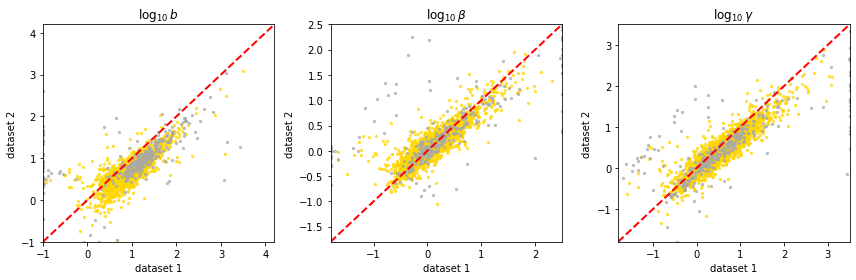

In [28]:
monod.analysis.plot_params_for_pair(sr_arr[2],sr_arr[5])

In [29]:
[x.sum() for x in cf]

[552, 363, 193, 5339, 3933, 1641]

INFO:root:Figure stored to ./fits/gg_221108_025_pbmc_celltypes_2/analysis_figures/parameter_residuals_10k.png.


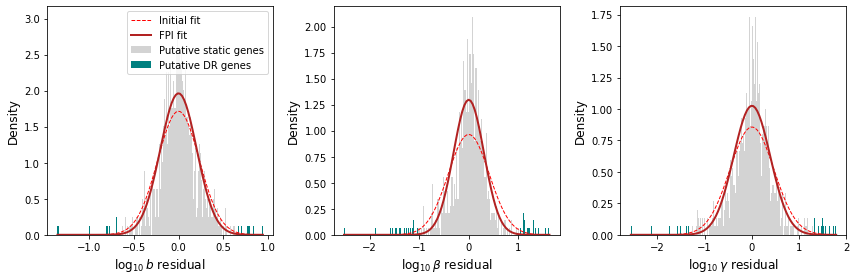

In [22]:
dr_analysis = []
# for j in range(2):
dr_analysis.append(monod.analysis.diffexp_pars(sr_arr[3],sr_arr[4],viz=True,modeltype='id',
                                   meta=dataset_meta[1],use_sigma=False,pval_thr=0.001,nit=20))


In [28]:
dr_analysis[0][-4]

[array(['THEMIS2', 'ITGB1', 'SPI1', 'OSBPL5', 'PRCP', 'CLECL1', 'NCOR2',
        'NAGK', 'CSF2RB', 'TTC38', 'CD38', 'GFOD1', 'CYBB'], dtype='<U17'),
 array(['SLAMF1', 'FCMR', 'PYHIN1', 'ATP8B2', 'DHRS3', 'PRKCQ-AS1', 'SPI1',
        'ETS1', 'CLEC4A', 'EVL', 'RASGRP1', 'ITGAX', 'CBFA2T3', 'CCR7',
        'TNRC6C', 'KYNU', 'ZAP70', 'SESTD1', 'NFATC2', 'CSF2RB', 'SEL1L3',
        'TBC1D9', 'TCF7', 'LY86', 'FGD2', 'SH2B2', 'TRIB1', 'SYK', 'CYBB',
        'CXorf21'], dtype='<U17'),
 array(['FCMR', 'PYHIN1', 'ATP8B2', 'PRKCQ-AS1', 'ETS1', 'CLEC4A', 'ALDH2',
        'RASGRP1', 'CBFA2T3', 'CCR7', 'ZAP70', 'NFATC2', 'PRR5', 'CSF2RB',
        'TBC1D9', 'TCF7', 'TRIB1', 'SYK'], dtype='<U17')]

In [31]:
markers_sep

[['CD3D',
  'CD3G',
  'CD3E',
  'CD247',
  'CD2',
  'TCF7',
  'CD4',
  'CCL5',
  'CD69',
  'CCL5'],
 ['CD93', 'CSTA', 'FPR1', 'CD14', 'CD36'],
 ['CD79A', 'CD22', 'BLK', 'IGHD', 'VPREB3']]

In [57]:
gf_rej = (~sr_arr[3].rejected_genes) & (~sr_arr[5].rejected_genes)
fc_par = (sr_arr[5].phys_optimum-sr_arr[3].phys_optimum)/np.log10(2)
# gf_rej = (~sr_arr[3].rejected_genes) & (~sr_arr[4].rejected_genes)
# fc_par = (sr_arr[4].phys_optimum-sr_arr[3].phys_optimum)/np.log10(2)

gf_mark_ = [np.where(gn == x)[0][0] for x in markers_sep[0]]
gf_mark_t = np.zeros(n_genes,dtype=bool)
gf_mark_t[gf_mark_] = True

# gf_mark_ = [np.where(gn == x)[0][0] for x in markers_sep[1]]
# gf_mark_mono = np.zeros(n_genes,dtype=bool)
# gf_mark_mono[gf_mark_] = True

gf_mark_ = [np.where(gn == x)[0][0] for x in markers_sep[2]]
gf_mark_b = np.zeros(n_genes,dtype=bool)
gf_mark_b[gf_mark_] = True

In [59]:
(sr_arr[5].rejected_genes).sum()

288

In [42]:
# gf_mark.sum()

<>:35: DeprecationWarning: invalid escape sequence \l
<>:36: DeprecationWarning: invalid escape sequence \l
<>:35: DeprecationWarning: invalid escape sequence \l
<>:36: DeprecationWarning: invalid escape sequence \l
/tmp/ipykernel_1595883/2387342294.py:35: DeprecationWarning: invalid escape sequence \l
  ax1[q].set_xlabel(raw_param_names[k1]+' $\log_2$ fold change')
/tmp/ipykernel_1595883/2387342294.py:36: DeprecationWarning: invalid escape sequence \l
  ax1[q].set_ylabel(raw_param_names[k2]+' $\log_2$ fold change')


NameError: name 'fc_par' is not defined

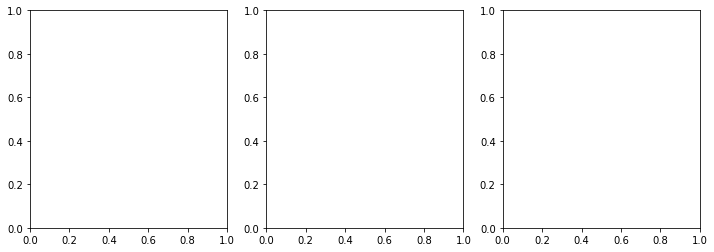

In [87]:
q=0

raw_param_names = (r'$b$',r'$\beta/k$',r'$\gamma/k$')

n_phys_pars = sr_arr[0].sp.n_phys_pars
n_genes = sr_arr[0].n_genes
pval_thr = 0.1/n_genes
param_names = sr_arr[0].model.get_log_name_str()
gn = sr_arr[0].gene_names
fs = 12



fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[0,1],[0,2],[1,2]]

q=0
for pair in pairs:
    k1 = pair[0]
    k2 = pair[1]
#     gf = 

    x = fc_par[:,k1]
    y = fc_par[:,k2]
#     x[np.isnan(x)] = 0 
#     y[np.isnan(y)] = 0

#     ax1[q].scatter(x[~gf],y[~gf],4,'darkgray',alpha=0.4)
#     ax1[q].scatter(x,y,4,'darkgray',alpha=0.4)
    ax1[q].scatter(x[gf_rej],y[gf_rej],4,'darkgray',alpha=0.4)
    ax1[q].scatter(x[gf_mark_t],y[gf_mark_t],50,'orange',alpha=0.4)
    ax1[q].scatter(x[gf_mark_b],y[gf_mark_b],50,'teal',alpha=0.4)
#     ax1[q].scatter(x[gf_mark_mono],y[gf_mark_mono],50,'teal',alpha=0.4)
#     ax1[q].scatter(x[gf],y[gf],50,'orange',alpha=0.4)
    ax1[q].set_xlabel(raw_param_names[k1]+' $\log_2$ fold change')
    ax1[q].set_ylabel(raw_param_names[k2]+' $\log_2$ fold change')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(x,y)[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    q+=1
fig1.tight_layout()


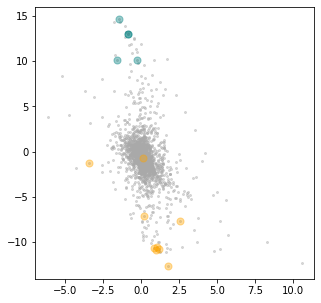

In [62]:
x = fc_par[:,0]
y = -(fc_par[:,1]+fc_par[:,2])
fig1,ax1=plt.subplots(1,1,figsize=(5,5))   
ax1.scatter(x,y,4,'darkgray',alpha=0.4)
# ax1.scatter(x[gf_rej],y[gf_rej],4,'darkgray',alpha=0.4)
ax1.scatter(x[gf_mark_t],y[gf_mark_t],50,'orange',alpha=0.4)
ax1.scatter(x[gf_mark_b],y[gf_mark_b],50,'teal',alpha=0.4)
# ax1.scatter(x[gf_mark_mono],y[gf_mark_mono],50,'teal',alpha=0.4)


INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.


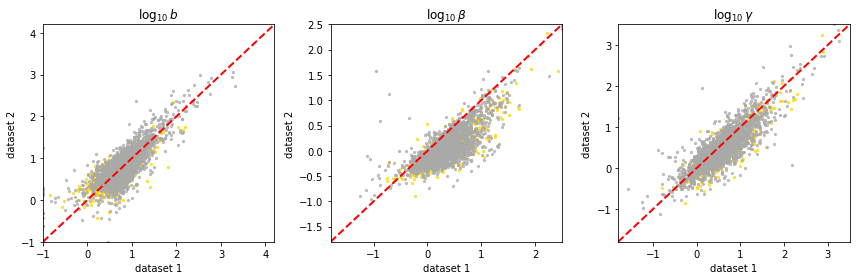

In [116]:
monod.analysis.plot_params_for_pair(sr_arr[3],sr_arr[11])

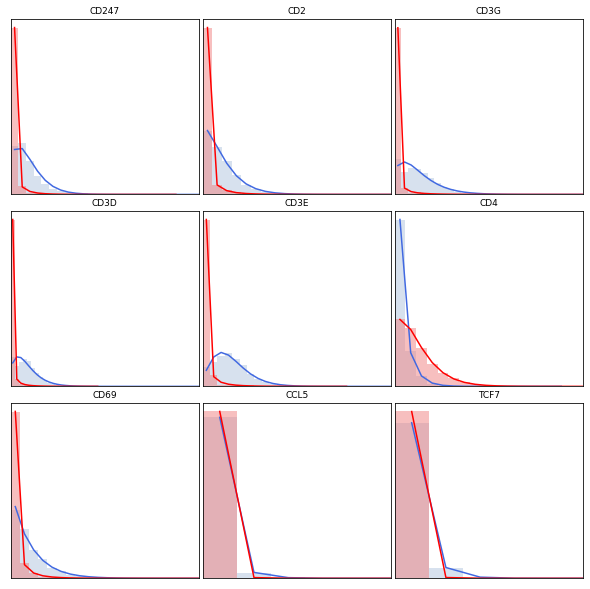

In [45]:
monod.analysis.compare_gene_distributions([sr_arr[3],sr_arr[4]],[sd_arr[3],sd_arr[4]],genes_to_plot=gf_mark_t,sz=(3,3),figsize=(8,8))

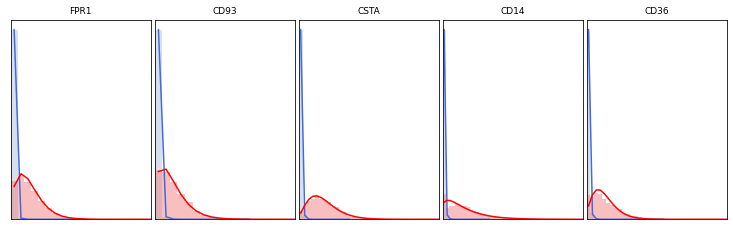

In [46]:
monod.analysis.compare_gene_distributions([sr_arr[3],sr_arr[4]],[sd_arr[3],sd_arr[4]],genes_to_plot=gf_mark_mono,sz=(1,5),figsize=(10,3))

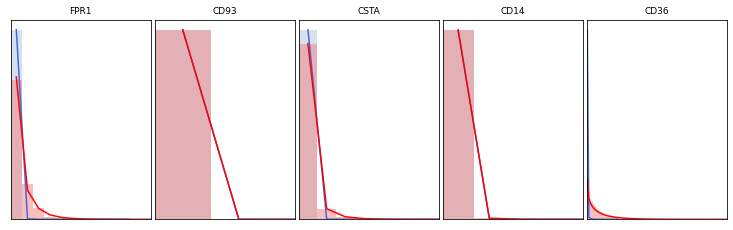

In [47]:
monod.analysis.compare_gene_distributions([sr_arr[3],sr_arr[4]],[sd_arr[3],sd_arr[4]],genes_to_plot=gf_mark_mono,sz=(1,5),figsize=(10,3),marg='nascent')

In [50]:
sr_arr[4].rejected_genes[gf_mark_mono]

array([ True,  True, False,  True,  True])

In [51]:
sr_arr[3].rejected_genes[gf_mark_mono]

array([ True,  True,  True, False,  True])

In [84]:
sr_arr[4].pval

array([8.99415859e-02, 8.50669148e-10, 1.45466440e-01, ...,
       1.43630753e-05, 7.82397709e-49, 6.85224801e-17])

In [83]:
sr_arr[3].phys_optimum[gf_mark_mono]

array([[-1.        ,  0.68386057,  0.40536765],
       [-1.        ,  2.43534984,  0.05366191],
       [-1.        ,  0.66731879, -0.12302229],
       [ 0.01687892,  0.41421333,  0.77973229],
       [ 0.0460508 ,  1.28807305,  0.74510595]])

INFO:root:Figure stored to ./fits/gg_221108_025_pbmc_celltypes_3/10x_pbmc_10k_Monocytes/Bursty_Poisson_20x21/analysis_figures/gene_distributions_nascent.png.


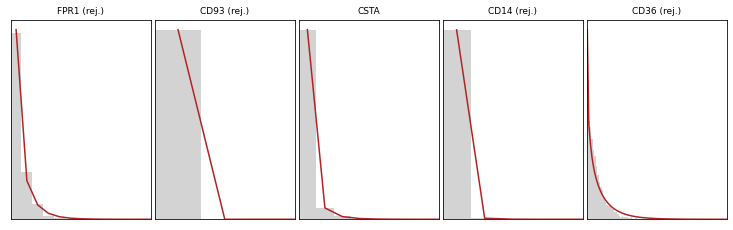

In [52]:
sr_arr[4].plot_gene_distributions(sd_arr[4],sz=(1,5),figsize=(10,3),marg='nascent',genes_to_plot=gf_mark_mono)

INFO:root:Figure stored to ./fits/gg_221108_025_pbmc_celltypes_3/10x_pbmc_10k_Monocytes/Bursty_Poisson_20x21/analysis_figures/gene_distributions_mature.png.


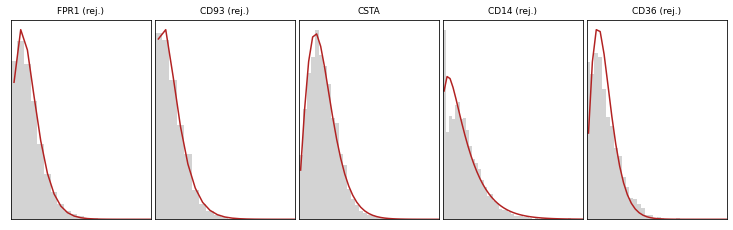

In [53]:
sr_arr[4].plot_gene_distributions(sd_arr[4],sz=(1,5),figsize=(10,3),marg='mature',genes_to_plot=gf_mark_mono)